In [4]:
# Import functions from the custom module
import numpy as np
from modules.functions import u_exact, rhs_func, setup_test
from scipy.sparse.linalg import gmres, LinearOperator
import matplotlib.pyplot as plt
from modules.Task0 import apply_diffusion_advection, matvec_with_boundary
from modules.Task1 import restarted_gmres_grid
from modules.Task2 import test_jacobi, test_residual, test_restriction, test_interpolation, test_mgv, MGV_iters, test_MGV_iters, mgv
from mpl_toolkits.mplot3d import Axes3D
import time

# Introduction

This project focuses on solving a 2D advection-diffusion equation using numerical methods. To be precise we will solve $$-\Delta u + v\nabla u = f $$ on the unit square, with constant velocity field $v=(1,1)$ for simplicity. We use the method of manufactured solution which allows for comparison with the exact solution throughout the project. The exact solution is chosen as $u(x, y) = \sin(\pi x) \sin(2\pi y)$, with the right-hand side $f$ and boundary conditions defined accordingly. This is convenient as we have zero boundary values for this problem. 

First we implement the restarted GMRES algorithm. Then we implement a multigrid V-cycle, where the restarted GMRES algorithm is used to solve the residual equation at the coarsest level. All operations are vectorized, and no costly explicit matrix operations are done to maximize performance. In doing so, we are able to solve a system of equation with a 1000x1000 matrix in under 10 seconds. 

### Task 1
In this task we implement the restarted GMRES algorithm in a function called restarted_gmres_grid. We have made plots of the computed and exact solutions, and the error. The plots look good, but the algorithm takes some time for convergence. This is because the resiudal is only decreased by a constant factor for these methods, and our matrix is not optimally condiditioned. We also plot the size of the residuals against the number of restarts for N=128. We see that we have linear convergence rate as expected. Further checking the number of iterations until convergence shows that the algorithm struggels to converge for large N relative to the subspace size m. This is quite reasonable, since the condition number increases when N increases.

In [9]:
#Define problem parameters
N = 64
X, Y, exact, f, h = setup_test(N)
v = (1, 1)

#Initialize U and f
U = np.zeros((N+1, N+1))  #Initial guess

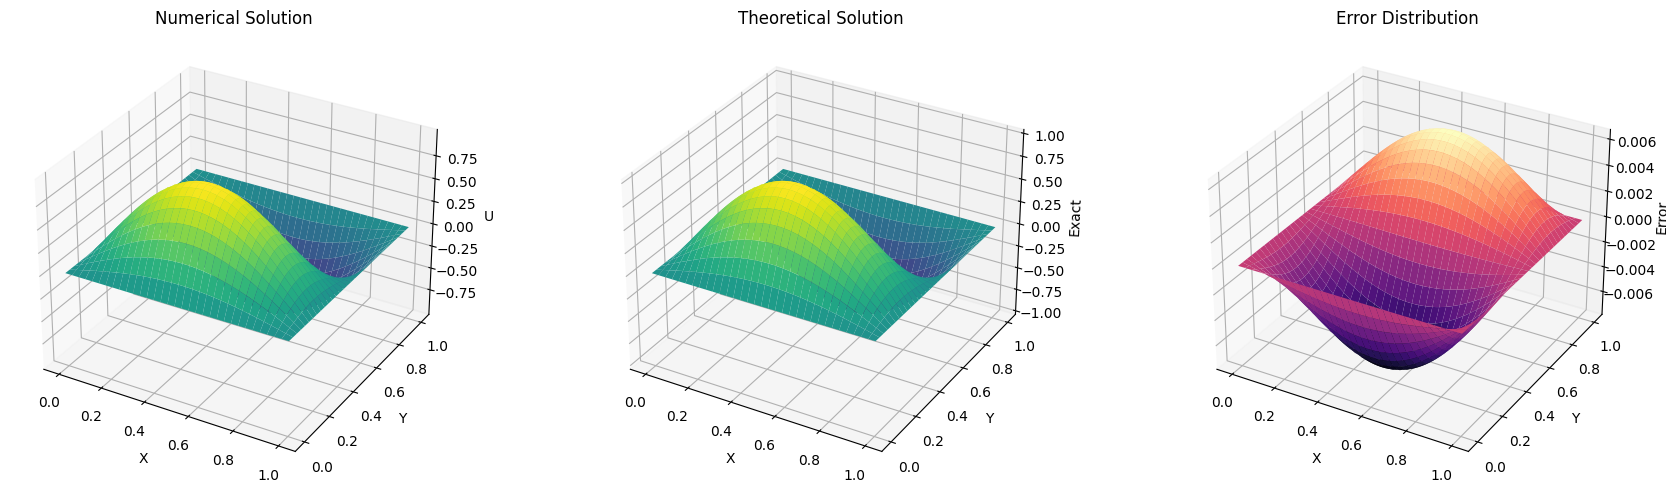

In [10]:
#Solve using restarted GMRES
U, _, _ = restarted_gmres_grid(U, f, N, h, v, tol=1e-8, m=40, max_restarts=20)

#Plot solutions
exact = u_exact(X, Y)
plot_solutions(U, exact, N)

Failed to converge within maximum restarts.
Converged in 20 restarts and 3.6070 seconds.


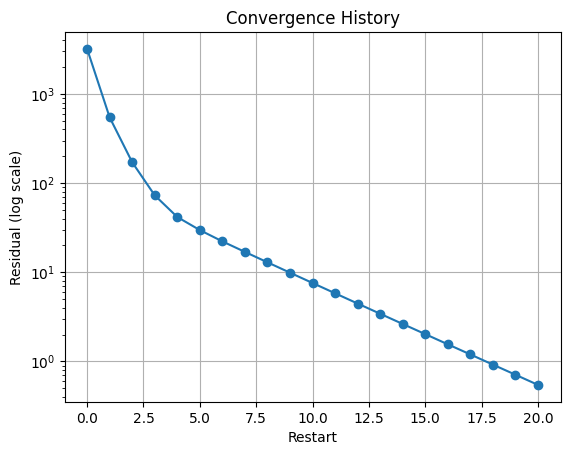

In [22]:
#Problem setup
N = 128
X, Y, exact, f, h = setup_test(N)
v = (1, 1)
tol = 1e-5
m = 30  #Subspace dimention 
U = np.zeros((N+1, N+1))  #Initial guess

#Solve using restarted GMRES
solution, residuals, elapsed_time = restarted_gmres_grid(U, f, N, h, v, tol, m, max_restarts=20, verbose=0)

#Print results
print(f"Converged in {len(residuals)-1} restarts and {elapsed_time:.4f} seconds.")

#Plot convergence history
plt.semilogy(residuals, marker='o')
plt.xlabel('Restart')
plt.ylabel('Residual (log scale)')
plt.title('Convergence History')
plt.grid(True)
plt.show()


In [3]:
#Define the grid sizes to test
Ns = [2**5, 2**6, 2**7, 2**8]
results = []

for N in Ns:
    X, Y, exact, f, h = setup_test(N)
    v = (1, 1)
    tol = 1e-6
    m = 20 
    U = np.zeros((N+1, N+1))  #Initial guess

    #Measure time and solve
    start_time = time.perf_counter()
    solution, residuals, elapsed_time = restarted_gmres_grid(U, f, N, h, v, tol, m, max_restarts=30, verbose=-1)
    end_time = time.perf_counter()

    #Store the results
    results.append({
        'N': N,
        'iterations': len(residuals) - 1,
        'time': elapsed_time
    })

#Print the results in a clear table format
print("\nGMRES Performance Results")
print(f"{'N':<10}{'Iterations':<15}{'Time (s)':<10}")
for result in results:
    print(f"{result['N']:<10}{result['iterations']:<15}{result['time']:<10.6f}")


Failed to converge within maximum restarts.
Failed to converge within maximum restarts.

GMRES Performance Results
N         Iterations     Time (s)  
32        8              0.104777  
64        23             0.726970  
128       30             3.236655  
256       30             12.884051 


### Task 2
In this task we implement the multigrid V-cycle for our problem. To do so we create functions to do the jacobi iteration, residual computation, restriction and interpolation. I have tested all these function agains the exact solution which can be viewd in the collapsed celles bellow. All these functions then make up the mgv function, where i use the restared GMRES from task 1 at the coarsest level. We then iterate until convergence in the MGV_iters function.

#### Jacobi iteration

Maximum error: 0.004413760663501187


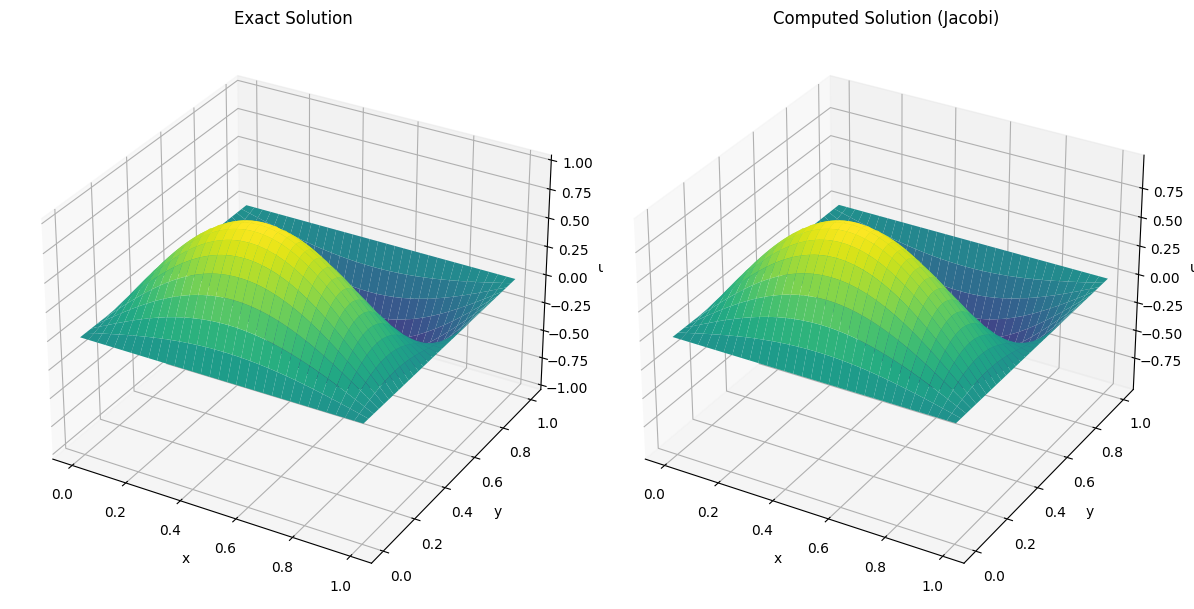

In [11]:
test_jacobi()

#### Residual computation

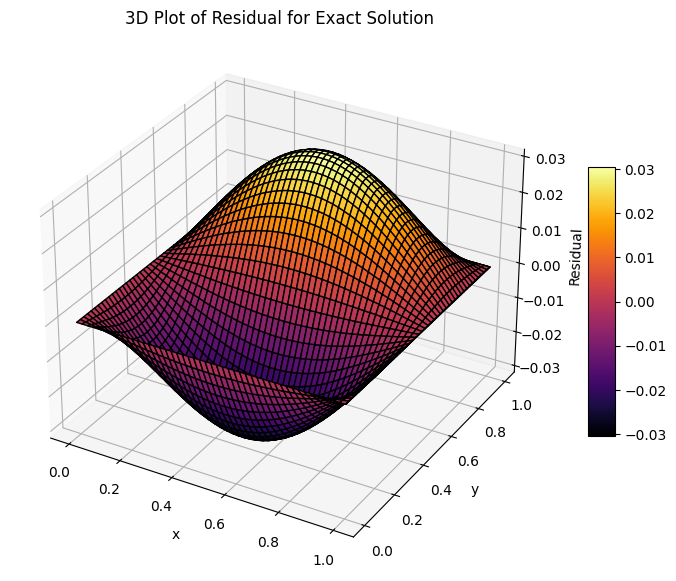

Max residual for the exact solution: 3.06e-02


In [12]:
test_residual(N=800)

#### Restriction

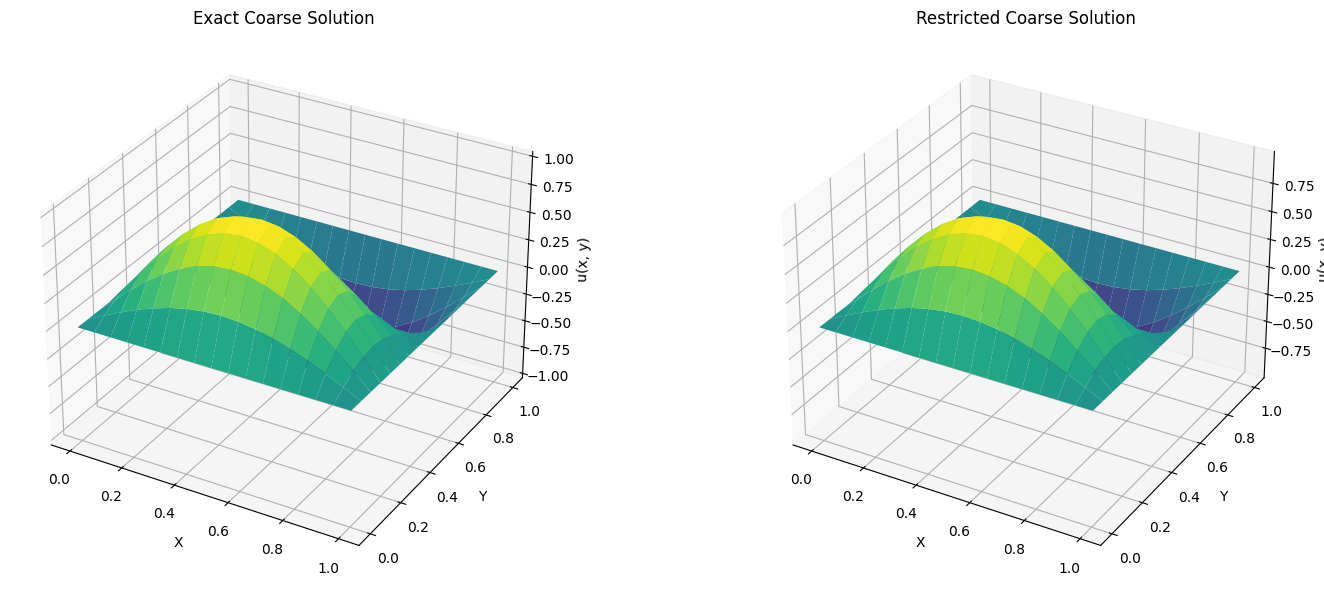

In [13]:
test_restriction(32)

#### Interpolation

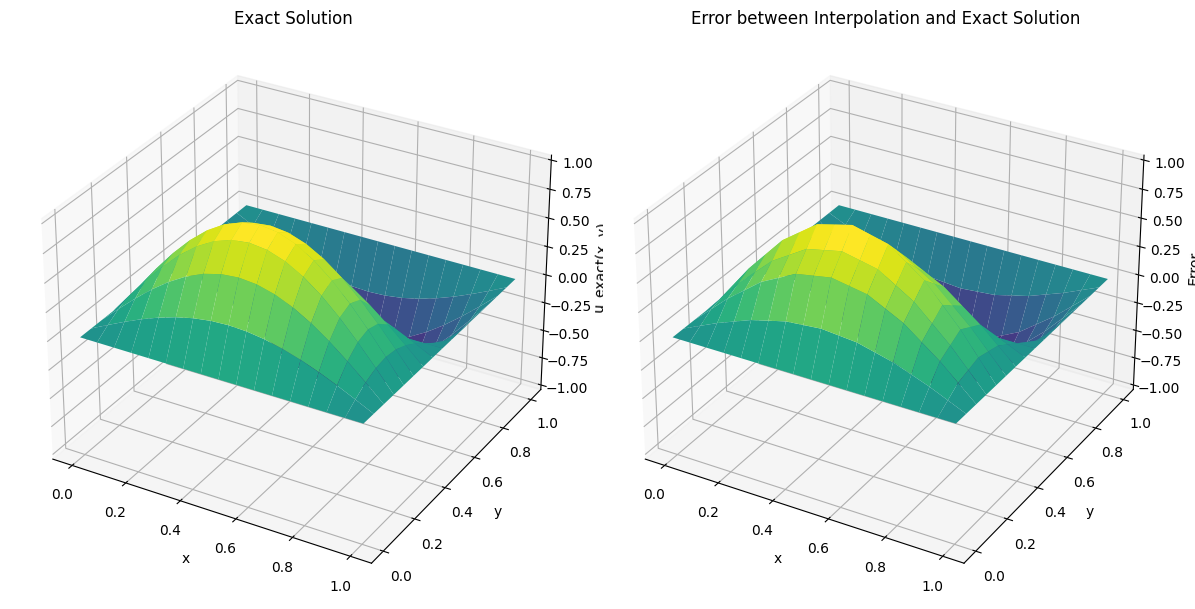

In [14]:
test_interpolation(8,16)

#### mgv

Level 1: Residual norm = 1.59e+03
Level 2: Residual norm = 7.88e+02
Level 3: Residual norm = 3.77e+02


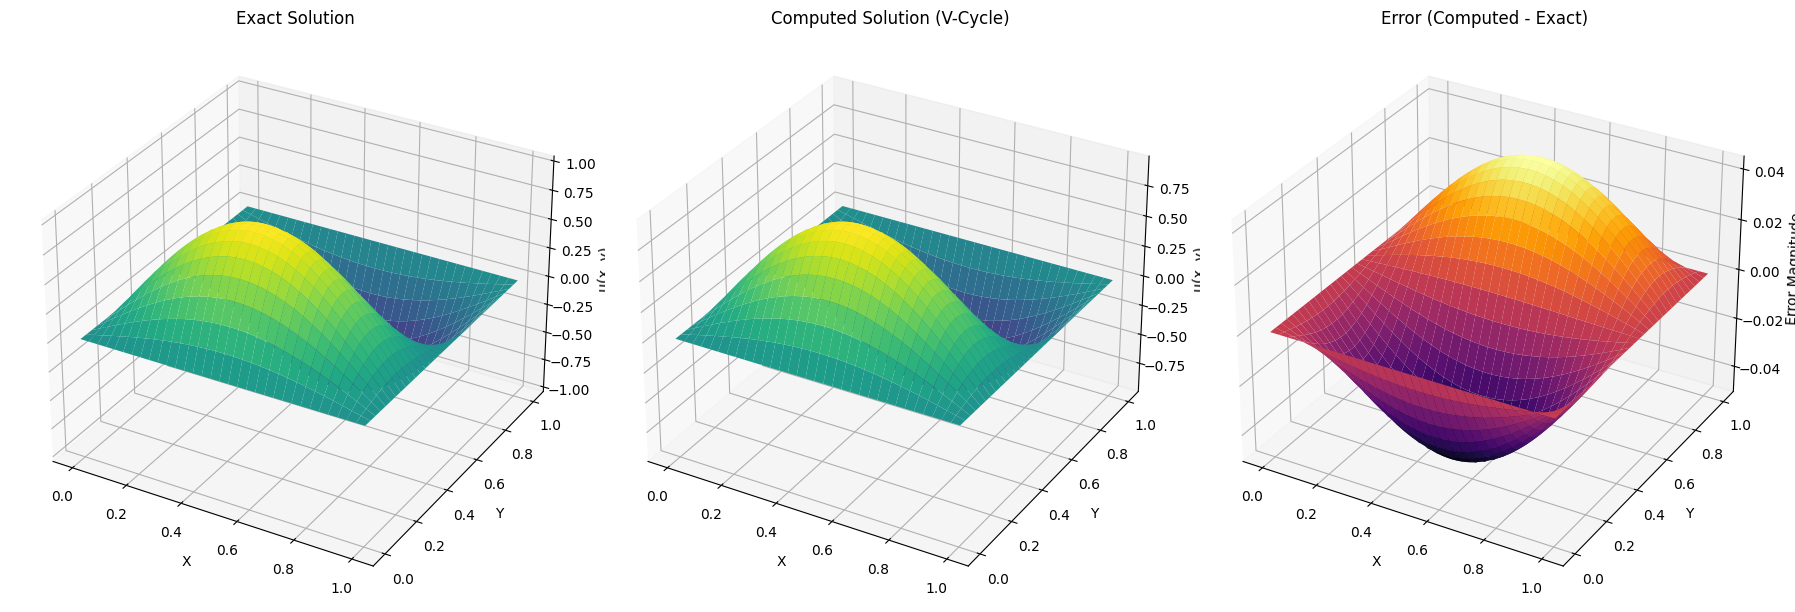

Max error between computed and exact solution: 4.870648e-02


In [2]:
test_mgv(2**6, 3, 4, 4)

#### Testing MGV_iters
First we plot the solution agains the exact solution to check that everything is working correctly. 

Converged at iteration 11: Residual norm = 2.47e-11
Max error 0.0017593939887264876
Last res norm 2.4734297452140797e-11


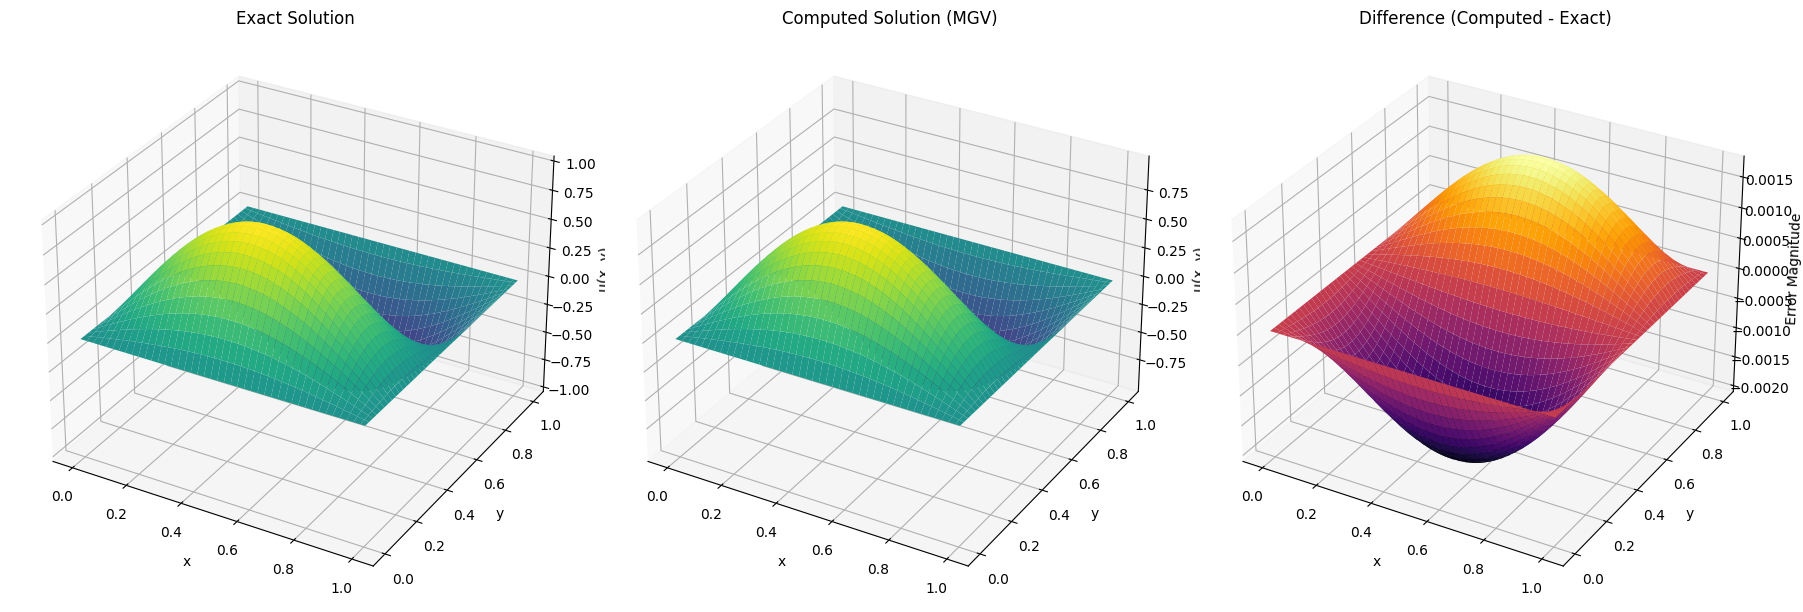

In [7]:
test_MGV_iters(2**8, 6, 8, 8, 1e-10)

Now we try to keep the coarsest level constant as we increase N. We observe that the computational cost increases as expected. We also see that the number of iterations til convergence remains constant, which is the point of multigrid methods. We also see that the convergence is linear on the log plot, which is expected as the residual should be reduced by a constant factor each iteration. 

In [5]:
#Define the grid sizes to test
Ns = [2**5, 2**6, 2**7, 2**8, 2**10]
nu1 = 6  #Number of pre-smoothing steps
nu2 = 6  #Number of post-smoothing steps
tol = 1e-6  #Convergence tolerance
max_iter = 100  #Maximum iterations

results_mgv = []

for N in Ns:
    X, Y, u, rhs, h = setup_test(N)
    max_level = int(np.log2(N)) - 2  #Calculate max_level
    v = [1, 1]  #Velocity field
    u0 = np.zeros((N+1, N+1))

    #Measure time and solve
    start_time = time.perf_counter()
    solution, residuals = MGV_iters(u0, rhs, v, N, nu1, nu2, max_level, tol, max_iter)
    elapsed_time = time.perf_counter() - start_time

    #Store results
    results_mgv.append({
        'N': N,
        'iterations': len(residuals) - 1,
        'time': elapsed_time,
        'residuals': residuals
    })


Converged at iteration 7: Residual norm = 3.23e-07
Converged at iteration 7: Residual norm = 5.90e-07
Converged at iteration 7: Residual norm = 7.62e-07
Converged at iteration 7: Residual norm = 8.57e-07
Converged at iteration 7: Residual norm = 9.33e-07


In [6]:
#Print the results in a clear table
print("\nMGV Performance Results")
print(f"{'N':<10}{'Max Level':<12}{'Iterations':<15}{'Time (s)':<10}")
for result in results_mgv:
    max_level = int(np.log2(result['N'])) - 2
    print(f"{result['N']:<10}{max_level:<12}{result['iterations']:<15}{result['time']:<10.6f}")



MGV Performance Results
N         Max Level   Iterations     Time (s)  
32        3           6              0.045585  
64        4           6              0.066553  
128       5           6              0.348058  
256       6           6              1.089062  
1024      8           6              9.108232  


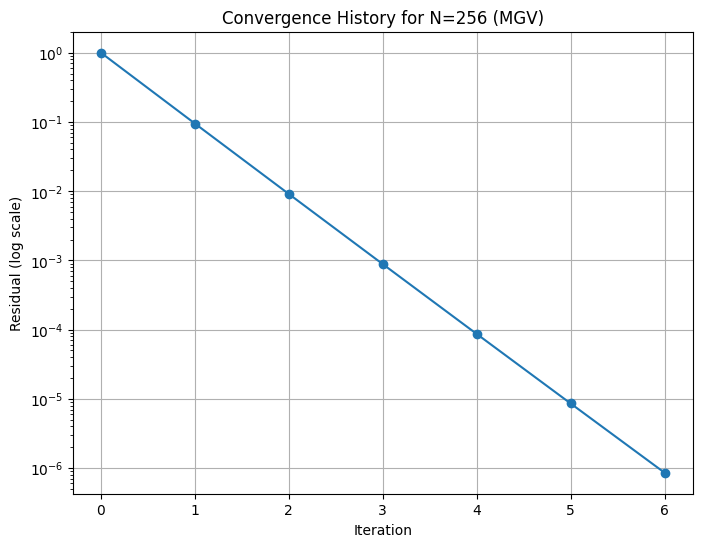

In [10]:
#Plot convergence history for the last N = 2^8
last_result = results_mgv[-1]  # Get the last result (N = 2^8)
plt.figure(figsize=(8, 6))
plt.semilogy(last_result['residuals'], marker='o')
plt.xlabel('Iteration')
plt.ylabel('Residual (log scale)')
plt.title(f'Convergence History for N={last_result["N"]} (MGV)')
plt.grid(True)
plt.show()


Max error 0.024591062372140038
Last res norm 0.05693402086689709


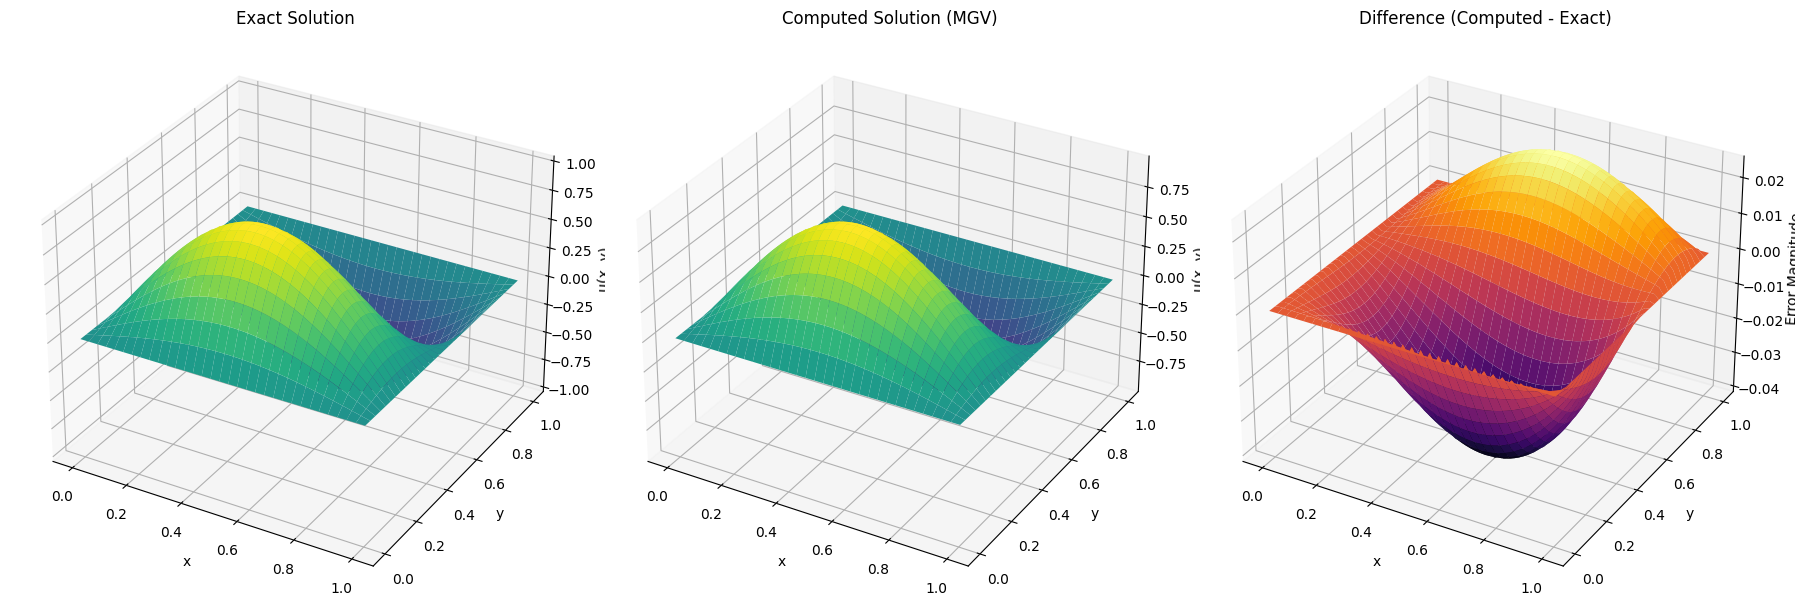

In [4]:
test_MGV_iters_vel(2**6, 4, 2, 2, 1e-6, (5,5))

In [5]:
# Define the grid sizes to test
Ns = [2**5, 2**6, 2**7, 2**8]
nu1 = 6  # Number of pre-smoothing steps
nu2 = 6  # Number of post-smoothing steps
tol = 1e-6  # Convergence tolerance
max_iter = 100  # Maximum iterations
v1 = 5
v2 = 5

results_mgv = []

for N in Ns:
    X, Y, u, rhs, h = setup_test_vel(N,v1,v2)
    max_level = int(np.log2(N)) - 2  # Calculate max_level
    v = [5, 5]  # Velocity field
    u0 = np.zeros((N+1, N+1))  # Random initial guess

    # Measure time and solve
    start_time = time.perf_counter()
    solution, residuals = MGV_iters(u0, rhs, v, N, nu1, nu2, max_level, tol, max_iter)
    elapsed_time = time.perf_counter() - start_time

    # Store results
    results_mgv.append({
        'N': N,
        'iterations': len(residuals) - 1,
        'time': elapsed_time,
        'residuals': residuals
    })


In [6]:
# Print the results in a clear table
print("\nMGV Performance Results")
print(f"{'N':<10}{'Max Level':<12}{'Iterations':<15}{'Time (s)':<10}")
for result in results_mgv:
    max_level = int(np.log2(result['N'])) - 2
    print(f"{result['N']:<10}{max_level:<12}{result['iterations']:<15}{result['time']:<10.6f}")



MGV Performance Results
N         Max Level   Iterations     Time (s)  
32        3           100            0.732390  
64        4           100            1.123783  
128       5           100            4.649019  
256       6           100            14.798277 


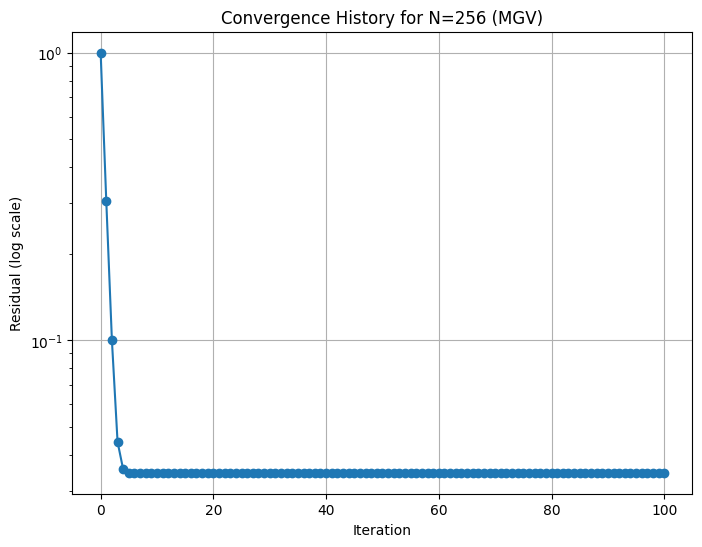

In [7]:
# Plot convergence history for the last N = 2^8
last_result = results_mgv[-1]  # Get the last result (N = 2^8)
plt.figure(figsize=(8, 6))
plt.semilogy(last_result['residuals'], marker='o')
plt.xlabel('Iteration')
plt.ylabel('Residual (log scale)')
plt.title(f'Convergence History for N={last_result["N"]} (MGV)')
plt.grid(True)
plt.show()


Starting Standard GMRES...
Preconditioned residual norm at iteration 1: 1.83e-02
Iteration 1: Residual norm = 1.56e+02
Preconditioned residual norm at iteration 2: 1.08e-02
Iteration 2: Residual norm = 1.12e+02
Preconditioned residual norm at iteration 3: 1.22e-02
Iteration 3: Residual norm = 1.12e+02
Preconditioned residual norm at iteration 4: 6.85e-03
Iteration 4: Residual norm = 1.12e+02
Preconditioned residual norm at iteration 5: 9.46e-03
Iteration 5: Residual norm = 1.12e+02
Preconditioned residual norm at iteration 6: 8.35e-03
Iteration 6: Residual norm = 1.12e+02
Preconditioned residual norm at iteration 7: 5.18e-03
Iteration 7: Residual norm = 1.12e+02
Preconditioned residual norm at iteration 8: 8.02e-03
Iteration 8: Residual norm = 1.12e+02
Preconditioned residual norm at iteration 9: 5.77e-03
Iteration 9: Residual norm = 1.12e+02
Preconditioned residual norm at iteration 10: 4.15e-03
Iteration 10: Residual norm = 1.12e+02
Preconditioned residual norm at iteration 11: 5.31e

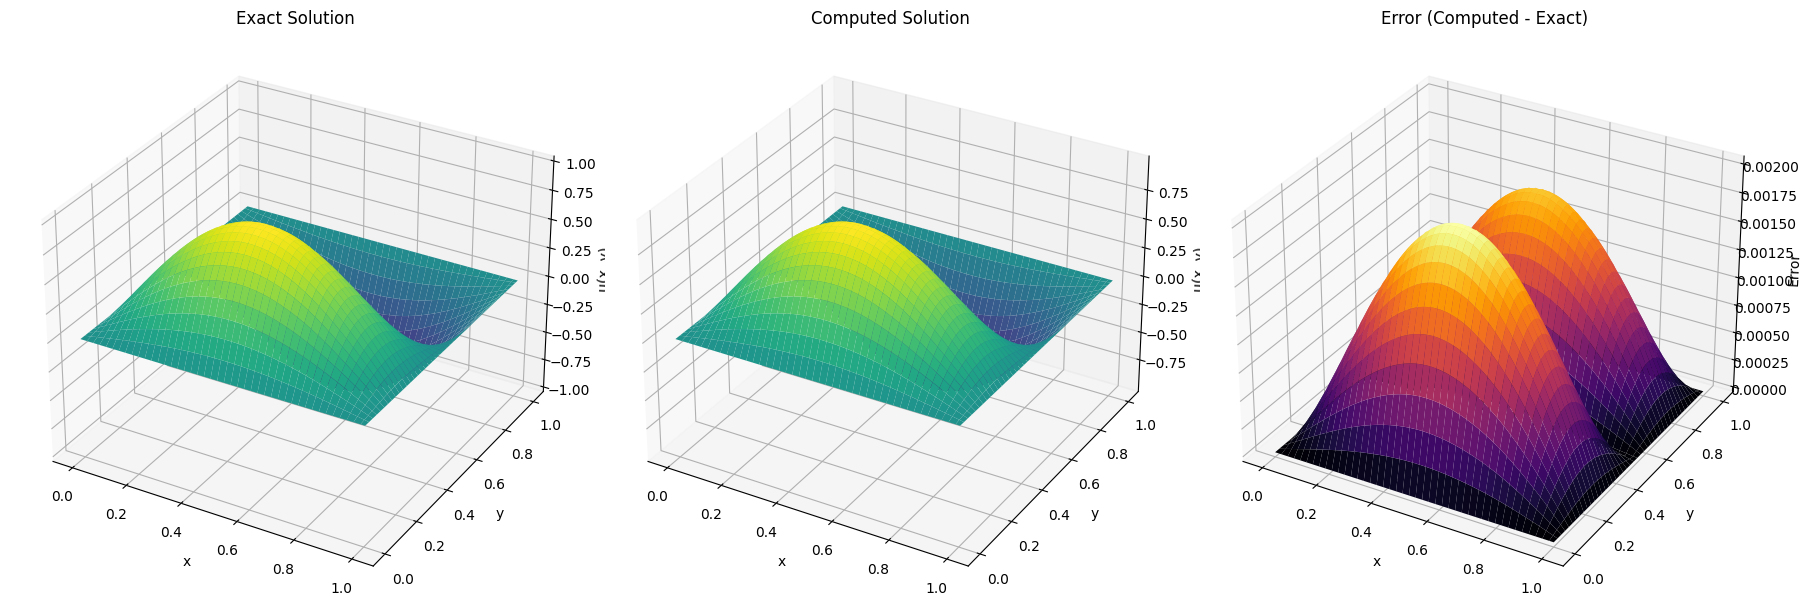

In [8]:
test_preconditioned_gmres(2**8, 8, 8, 6, 1e-6)